# Nationwide Customer Profile Analysis

In [1]:
# Imports
import os
import requests
import json
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import plotly.express as px

In [2]:
# Read the Census API Key
load_dotenv()
CENSUS_API_KEY = os.getenv("census")
map_box_api = os.getenv("mapbox")

In [3]:
# Census URL
census_url = 'https://api.census.gov/data/2019/acs/acs1/subject?get=NAME,S0102_C01_028E,S0102_C02_076E,S0601_C03_006E,S0601_C03_035E,S0601_C03_036E,S0601_C03_037E&for=county:*&key=' + CENSUS_API_KEY

In [10]:
# Fetiching Required Census data from an API
res_data = requests.get(census_url).json()

In [11]:
# Convert the Census Data into a DataFrame
census_data = pd.DataFrame(res_data[1:], columns=res_data[0])
census_data.head()

,NAME,S0102_C01_028E,S0102_C02_076E,S0601_C03_006E,S0601_C03_035E,S0601_C03_036E,S0601_C03_037E,state,county
0,"Jefferson County, Kentucky",44.1,64495,13.2,30.3,25.5,18.6,21,111
1,"Hennepin County, Minnesota",47.1,85434,15.0,24.8,35.9,23.8,27,053
2,"Olmsted County, Minnesota",None,None,12.8,23.8,29.0,30.7,27,109
3,"Scott County, Minnesota",None,None,22.3,28.8,39.3,15.8,27,139
4,"Faulkner County, Arkansas",None,None,14.8,35.1,21.0,9.5,05,045


In [12]:
# Split the NAME column into County and State
census_data[['County', 'State']] = census_data['NAME'].str.split(',', 1, expand=True)
census_data['County'] = census_data['County'].str.split(expand=True)

# Drop the NAME Column
census_data.drop(columns='NAME', inplace=True)
census_data.head()

,S0102_C01_028E,S0102_C02_076E,S0601_C03_006E,S0601_C03_035E,S0601_C03_036E,S0601_C03_037E,state,county,County,State
0,44.1,64495,13.2,30.3,25.5,18.6,21,111,Jefferson,Kentucky
1,47.1,85434,15.0,24.8,35.9,23.8,27,053,Hennepin,Minnesota
2,None,None,12.8,23.8,29.0,30.7,27,109,Olmsted,Minnesota
3,None,None,22.3,28.8,39.3,15.8,27,139,Scott,Minnesota
4,None,None,14.8,35.1,21.0,9.5,05,045,Faulkner,Arkansas


In [13]:
# Drop state code and county code columns
census_data.drop(columns=['state','county'], inplace=True)

In [14]:
# Education Count Column = All the College Degree +  Bachelor Degree + professional Degree Population
census_data['Education_Pop'] = census_data['S0601_C03_035E'].astype(np.float) + census_data['S0601_C03_036E'].astype(np.float) + census_data['S0601_C03_037E'].astype(np.float)
census_data.drop(columns=['S0601_C03_035E','S0601_C03_036E','S0601_C03_037E'], inplace=True)
census_data.head()

,S0102_C01_028E,S0102_C02_076E,S0601_C03_006E,County,State,Education_Pop
0,44.1,64495,13.2,Jefferson,Kentucky,74.4
1,47.1,85434,15.0,Hennepin,Minnesota,84.5
2,None,None,12.8,Olmsted,Minnesota,83.5
3,None,None,22.3,Scott,Minnesota,83.9
4,None,None,14.8,Faulkner,Arkansas,65.6


In [15]:
# Defining each column with Meaningfull data definition
census_data.rename(columns={
    'S0102_C01_028E': 'Marital_Pop',
    'S0102_C02_076E': 'Income',
    'S0601_C03_006E': 'Age_Pop'
}, inplace=True)
census_data.head()

,Marital_Pop,Income,Age_Pop,County,State,Education_Pop
0,44.1,64495,13.2,Jefferson,Kentucky,74.4
1,47.1,85434,15.0,Hennepin,Minnesota,84.5
2,None,None,12.8,Olmsted,Minnesota,83.5
3,None,None,22.3,Scott,Minnesota,83.9
4,None,None,14.8,Faulkner,Arkansas,65.6


In [16]:
# dropping all the None values
census_data.dropna(inplace=True)

In [17]:
# Remove all the duplicates
census_data.drop_duplicates(inplace=True)

In [18]:
# inspecting Data Types
census_data.dtypes

Marital_Pop       object
Income            object
Age_Pop           object
County            object
State             object
Education_Pop    float64
dtype: object

In [20]:
# Converting String Numeric columns to Numeric
census_data['Marital_Pop'] = census_data['Marital_Pop'].astype(np.float)
census_data['Income'] = census_data['Income'].astype(np.int)
census_data['Age_Pop'] = census_data['Age_Pop'].astype(np.float)
census_data['Education_Pop'] = census_data['Education_Pop'].astype(np.float)

In [21]:
# Checking a sample of census_data
census_data.head()

,Marital_Pop,Income,Age_Pop,County,State,Education_Pop
0,44.1,64495,13.2,Jefferson,Kentucky,74.4
1,47.1,85434,15.0,Hennepin,Minnesota,84.5
6,48.6,57972,13.7,Sedgwick,Kansas,68.0
9,45.7,80766,11.4,Allegheny,Pennsylvania,82.0
14,54.8,104728,16.0,Chester,Pennsylvania,84.0


- - -

## States and Countys which are (60K-80K) Income, (40 - 60) Age, Educated and Married

In [22]:
# Fetch Geo Codes and append to the existing DataFrame
def geo_coordinates(df):
    # Geolocator object
    geolocator = Nominatim(user_agent="http")
    Lat_list, Long_list = [], []
    
    # Iterate eah rows and get County and State and passing to geolocator
    for i, row in df[['County','State']].iterrows():
        coordinates = geolocator.geocode(f"{row['County']}, {row['State']}")
        
        # Append the latitude to Lat_list
        Lat_list.append(coordinates.latitude)
        
        # Append the latitude to Long_list
        Long_list.append(coordinates.longitude)
    
    new_data = pd.DataFrame({
        'Lat': Lat_list,
        'Lon': Long_list
    })
    
    # Reset the index before joining
    df.reset_index(drop=True, inplace=True)
    
    # Concat the existing df with the new data and return
    return pd.concat([df,new_data], axis='columns', join='inner')

In [23]:
# Records which has income 60K to 80K
top_income_df = census_data.loc[(census_data['Income']>=60000) & (census_data['Income']<=80000)]
top_income_df.head()

,Marital_Pop,Income,Age_Pop,County,State,Education_Pop
0,44.1,64495,13.2,Jefferson,Kentucky,74.4
21,44.7,60722,12.2,Jackson,Missouri,68.7
31,51.5,76660,15.9,Williamson,Texas,78.1
43,51.7,75104,16.0,Will,Illinois,71.3
73,42.1,71318,15.1,Duval,Florida,66.8


In [35]:
# Group them by State and County
df = top_income_df.groupby(['State', 'County']).sum()

In [36]:
# Rank column which has total of Marital_Pop, Age_Pop and Education_Pop
df['Rank'] = df[['Marital_Pop', 'Age_Pop', 'Education_Pop']].sum(axis=1)
df.head()

Marital_Pop  Income  Age_Pop  Education_Pop   Rank
State       County                                                       
 Alabama    Jefferson         44.3   65833     15.0           75.6  134.9
 Arizona    Maricopa          46.7   77186     14.8           74.3  135.8
 California Fresno            44.2   72806     12.3           66.9  123.4
            Kern              45.2   78001     11.9           61.8  118.9
            Riverside         47.3   77961     11.7           70.7  129.7

In [37]:
# Top 10 States and its countys which has highest Marital Population, Age (40-60) Population and Most Educated
df = df.sort_values('Rank', ascending=False).iloc[:10].reset_index()
df

,State,County,Marital_Pop,Income,Age_Pop,Education_Pop,Rank
0,Georgia,Gwinnett,52.8,79612,17.5,78.7,149.0
1,Wisconsin,Dane,46.4,77379,13.1,86.7,146.2
2,Texas,Williamson,51.5,76660,15.9,78.1,145.5
3,Colorado,El,52.8,76095,12.9,78.2,143.9
4,South Carolina,Greenville,49.8,66334,15.0,79.1,143.9
5,Oregon,Multnomah,41.3,72965,14.9,84.5,140.7
6,Illinois,Will,51.7,75104,16.0,71.3,139.0
7,Washington,Spokane,48.9,74279,14.1,74.1,137.1
8,Minnesota,Ramsey,42.8,72572,13.9,80.4,137.1
9,Nebraska,Douglas,48.1,78910,14.0,74.8,136.9


In [38]:
# Get the Latitude and Longitude coordinates
df = geo_coordinates(df)
df

,State,County,Marital_Pop,Income,Age_Pop,Education_Pop,Rank,Lat,Lon
0,Georgia,Gwinnett,52.8,79612,17.5,78.7,149.0,33.956687,-84.022747
1,Wisconsin,Dane,46.4,77379,13.1,86.7,146.2,43.250547,-89.501509
2,Texas,Williamson,51.5,76660,15.9,78.1,145.5,30.658093,-97.604165
3,Colorado,El,52.8,76095,12.9,78.2,143.9,38.725178,-105.607716
4,South Carolina,Greenville,49.8,66334,15.0,79.1,143.9,34.851354,-82.398488
5,Oregon,Multnomah,41.3,72965,14.9,84.5,140.7,45.466151,-122.712787
6,Illinois,Will,51.7,75104,16.0,71.3,139.0,41.419406,-87.999475
7,Washington,Spokane,48.9,74279,14.1,74.1,137.1,47.657193,-117.423511
8,Minnesota,Ramsey,42.8,72572,13.9,80.4,137.1,45.016573,-93.094950
9,Nebraska,Douglas,48.1,78910,14.0,74.8,136.9,41.295411,-96.141567


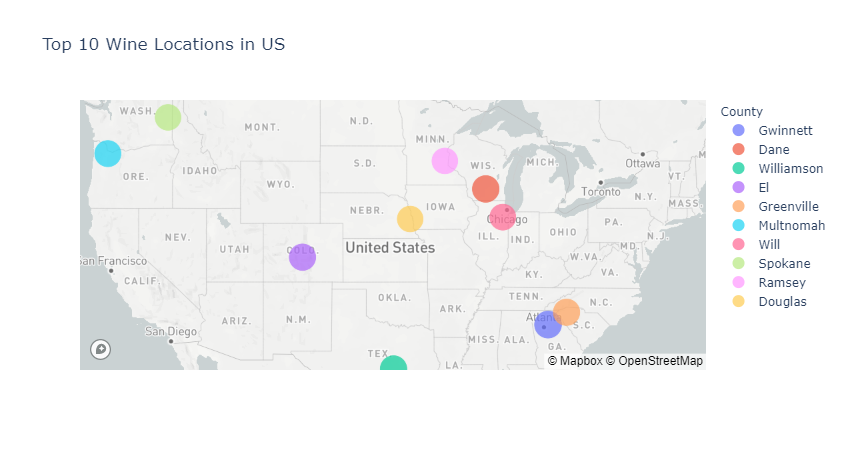

In [43]:
# Set the mapbox access token
px.set_mapbox_access_token(map_box_api)

# Create a scatter mapbox to analyze neighborhood info
map_plot = px.scatter_mapbox(
    df,
    lat='Lat',
    lon='Lon',
    color='County',
    size='Rank',
    title='Top 10 Wine Locations in US',
    color_continuous_scale=px.colors.sequential.Rainbow,
    size_max=20,
    zoom=3
)
#map_plot.update_traces(marker={'size': 12})
map_plot.show()